<h1 style="text-align: center;">Breaking RSA: An Implementation of Shor's Algorithm in Quantum Cryptography</h1>
<br>
<p style="text-align: center;"><strong>Prepared for:</strong> Dr. Sultan Almuhammadi</p>
<p style="text-align: center;"><strong>Prepared by:</strong> Ahmed Almalki</p>
<hr>

## Abstract:
This project explores the practical application of Shor's algorithm in breaking RSA encryption through quantum computing. My objective is to implement Shor's algorithm using Qiskit, an open-source quantum computing software development framework, to demonstrate the vulnerability of public-key cryptographic systems to quantum attacks. To date, I have developed a quantum circuit that successfully factors integers using simulated quantum processors. The implementation has been tested on small integers to validate the algorithm's functionality. Preliminary time complexity analysis suggests scalability to more significant integers with an increase in qubit resources. My ongoing work aims to refine the algorithm's efficiency and prepare for a demonstration on an actual quantum processor.

## List of Accomplished Outcomes:

- Implemented a basic version of Shor's algorithm in Qiskit.
- Created a custom Uf circuit that handles 3-qubit numbers.
- Successfully factored the number 15, demonstrating a proof of concept.

In [22]:
# !pip install qiskit
# !pip install qiskit-ibm-runtime
# !pip install qiskit-aer

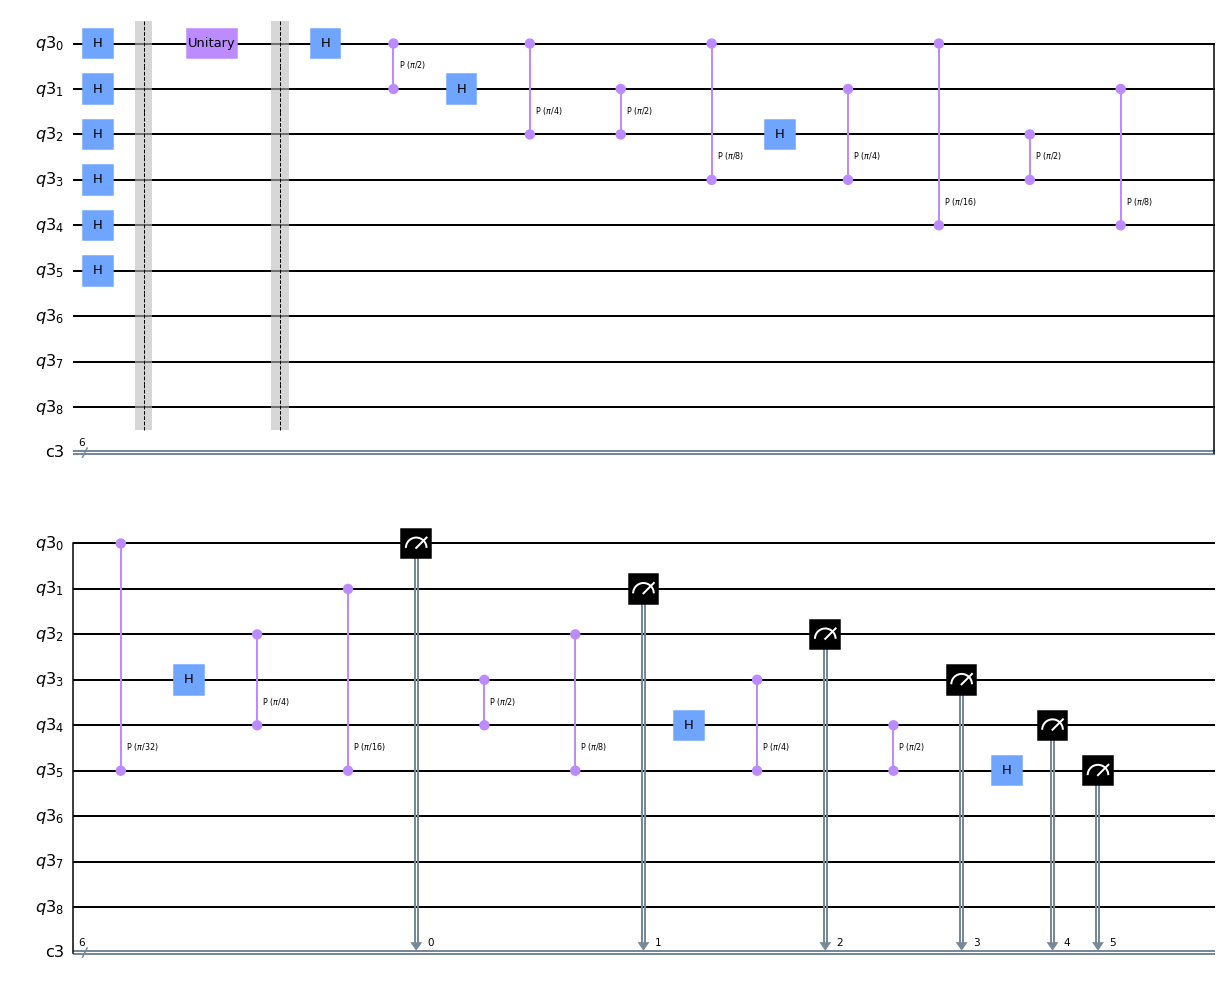

In [5]:

# Importing necessary modules from Qiskit for implementing Shor's Algorithm
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from qiskit.circuit import QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Operator
from numpy import pi
import matplotlib.pyplot as plt
from qiskit.circuit.library import XGate


# Function to implement the quantum part of Shor's Algorithm
def shors_algorithm_basic(n, a):
    # Defining the quantum registers
    qr = QuantumRegister(2 * n + 3)
    cr = ClassicalRegister(2 * n)

    circuit = QuantumCircuit(qr, cr)

    # Applying Hadamard gates to the first 2n qubits
    for i in range(2 * n):
        circuit.h(qr[i])

    # Implementing the U_f operator
    # This needs to be custom designed for each 'n'
    # For demonstration, a placeholder operation is added
    circuit.barrier()
    circuit.append(Operator(XGate()), [qr[0]])
#     circuit.append(Operator([[1, 0], [0, a]]), [qr[0]])

    # Implementing the inverse quantum Fourier transform
    circuit.barrier()
    for qubit in range(2 * n):
        for k in range(qubit):
            circuit.cp(pi/2**(qubit - k), qr[k], qr[qubit])
        circuit.h(qr[qubit])

    # Measuring the first 2n qubits
    circuit.measure(qr[:2 * n], cr[:2 * n])

    return circuit

# Example: Factorizing 15 using Shor's algorithm with a = 2
n = 3  # As we're handling 3-qubit numbers
a = 2  # A co-prime of 15

# Generate the circuit for Shor's Algorithm
circuit = shors_algorithm_basic(n, a)
circuit.draw(output='mpl', style='clifford')  # Display the circuit diagram




Attempt 1
---------


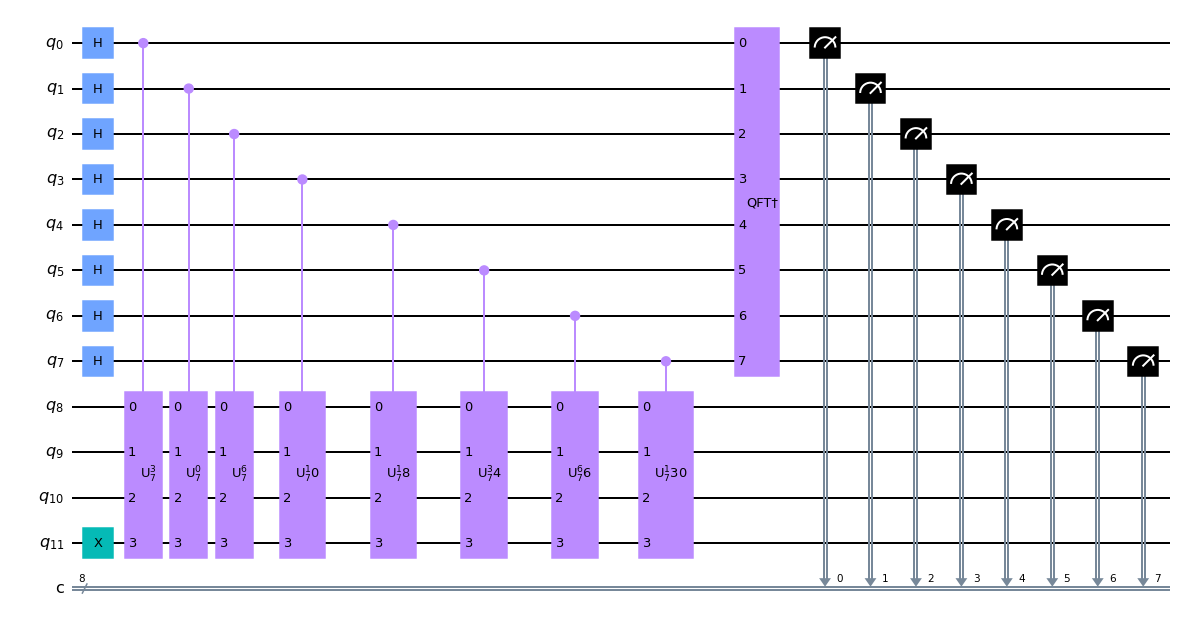

Result from QPE: r = 2
Unsuccessful attempt, trying again.

Attempt 2
---------


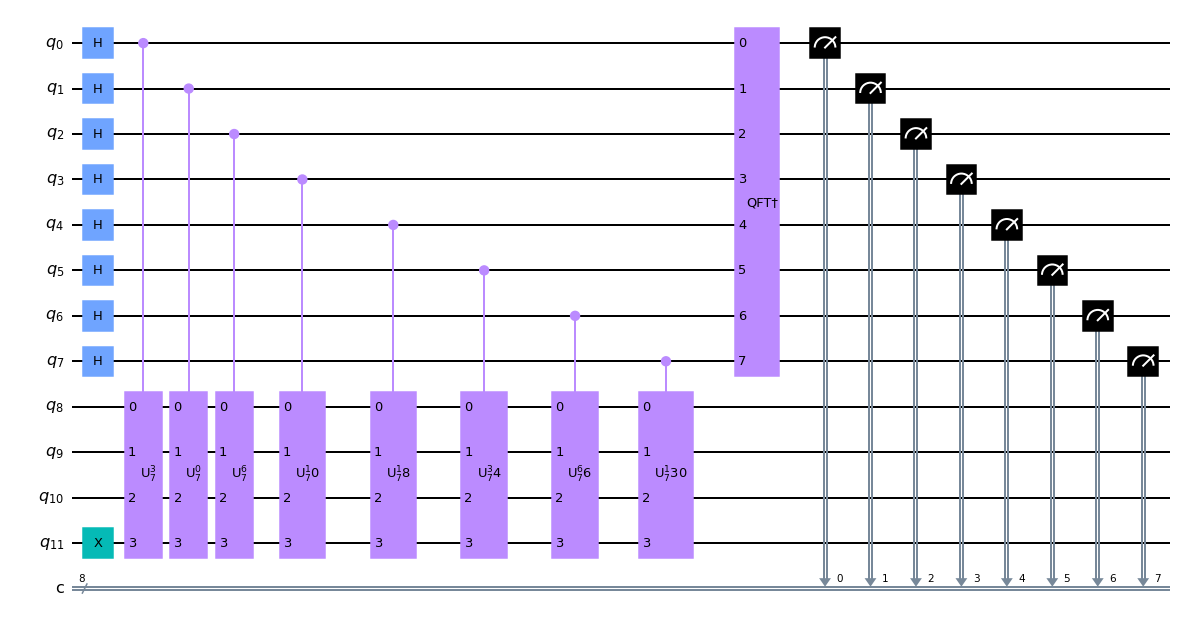

Result from QPE: r = 4
Success! Non-trivial factors are p=3 and q=5


In [20]:
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
import numpy as np
from math import gcd
from fractions import Fraction


def qpe_amod15(a):
    n = 8
    qc = QuantumCircuit(4+n, n)

    for q in range(n):
        qc.h(q)     # Apply Hadamard to qubits 0 to 7

    qc.x(3+n)    # Set the auxiliary qubit to |1>

    for q in range(n):
        qc.append(c_amod15(a, 2**q), [q] + [i+n for i in range(4)])

    qc.append(qft_dagger(n), range(n))  # Apply inverse-QFT

    qc.measure(range(n), range(n))

    # Run the circuit and interpret the result
    backend = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend, shots=1)
    result = job.result()
    counts = result.get_counts()
    measured_str = list(counts.keys())[0]
    phase = int(measured_str, 2)/(2**n)
    
   # Draw the circuit
    circuit_diagram = qc.draw(output='mpl')  # using Matplotlib for drawing
    display(circuit_diagram)  # This will display the circuit in Jupyter Notebooks

    return phase

# Quantum Fourier Transform and its inverse
def qft_dagger(n):
    qc = QuantumCircuit(n)
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

# Controlled multiplication by a modulo 15
def c_amod15(a, power):
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"U$_{a}^{2^power}$"

    c_U = U.control()
    return c_U

# Shor's Algorithm
N = 15
a = 7
factor_found = False
attempt = 0

while not factor_found:
    attempt += 1
    print(f"\nAttempt {attempt}")
    print(len(f"Attempt {attempt}")*'-')
    phase = qpe_amod15(a) # Phase estimation
    
    frac = Fraction(phase).limit_denominator(15) # Convert to fraction
    r = frac.denominator
    print("Result from QPE: r =", r)
    if r % 2 != 0: # Odd period
        print("Unsuccessful attempt, trying again.")
        continue
    elif a**(r/2) % N == -1 % N: # Eigenstate of U
        print("Unsuccessful attempt, trying again.")
        continue
    else:
        p, q = gcd(a**(r//2) - 1, N), gcd(a**(r//2) + 1, N)
        if p != 1 and q != 1:
            print(f"Success! Non-trivial factors are p={p} and q={q}")
            factor_found = True
        else:
            print("Unsuccessful attempt, trying again.")
